In [ ]:
#######################################################################################
!pip install torch torchvision torchaudio --quiet
!pip install numpy pandas scikit-learn tqdm matplotlib --quiet
########################################################################################

!git clone https://github.com/HelenGuohx/logbert.git
%cd logbert


!ls


import sys
sys.path.append("/content/logbert")  # Add root folder to Python path


import torch
from bert_pytorch.model.log_model import BERTLog
from bert_pytorch.model.bert import BERT
import torch.nn as nn


vocab_size = 10000        # Total unique log keys in your dataset
max_len = 128             # Sequence length
hidden = 768              # Hidden size
n_layers = 12             # Transformer blocks
attn_heads = 12           # Attention heads
dropout = 0.3
is_logkey = True
is_time = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


bert_model = BERT(
    vocab_size=vocab_size,
    max_len=max_len,
    hidden=hidden,
    n_layers=n_layers,
    attn_heads=attn_heads,
    dropout=dropout,
    is_logkey=is_logkey,
    is_time=is_time
).to(device)


class BERTLog(nn.Module):
    def __init__(self, bert, vocab_size):
        super().__init__()
        self.bert = bert
        self.logkey_predictor = nn.Linear(bert.hidden, vocab_size)
        if self.bert.is_time:
            self.time_predictor = nn.Linear(bert.hidden, bert.max_len) # Example output size, adjust as needed
        else:
            self.time_predictor = None

        # Add classification heads if they exist in your original model structure
        if hasattr(bert, 'cls_head'):
             self.cls_head = bert.cls_head
        if hasattr(bert, 'cls_fnn'):
            self.cls_fnn = bert.cls_fnn


    def forward(self, x, time_info=None):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)
        encoded_layers = self.bert(x, time_info, mask) # Original forward pass

        logkey_output = self.logkey_predictor(encoded_layers)
        time_output = None
        if self.time_predictor:
            time_output = self.time_predictor(encoded_layers)

        # Include classification head outputs if available
        cls_output = None
        if hasattr(self, 'cls_head'):
            cls_output = self.cls_head(encoded_layers[:, 0]) # Assuming CLS token at index 0

        cls_fnn_output = None
        if hasattr(self, 'cls_fnn'):
            cls_fnn_output = self.cls_fnn(encoded_layers[:, 0]) # Assuming CLS token at index 0


        return {'logkey_output': logkey_output,
                'time_output': time_output,
                'cls_output': cls_output,
                'cls_fnn_output': cls_fnn_output}

    def forward_from_embedding(self, x_emb, time_info=None):
        # Assume x_emb is already token embeddings [batch, seq_len, embedding_dim]
        # We need a dummy mask based on the original input shape
        # Since we don't have the original tokens, we'll create a mask assuming non-padding
        # This might need refinement based on how your model handles padding after embedding
        dummy_x = torch.ones(x_emb.shape[0], x_emb.shape[1], dtype=torch.long, device=x_emb.device) # Dummy input for mask
        mask = (dummy_x > 0).unsqueeze(1).repeat(1, dummy_x.size(1), 1).unsqueeze(1)


        # Pass embedding directly to BERT's core layers (after embedding and positional encoding)
        # This requires access to BERT's internal layers.
        # Need to replicate the steps in bert_pytorch.model.bert.BERT.forward() after embedding
        # This might be complex and require modifying the original BERT class as well.
        # For simplicity, let's assume the BERT model can take embeddings directly after positional encoding
        # *********** This part needs adjustment based on the actual BERT implementation *************
        # Assuming bert_model has a method or can be modified to accept pre-computed embeddings
        # For now, let's call the main forward and hope it handles pre-computed embeddings if possible
        # If not, the BERT class needs modification.

        # A more correct approach might be to access BERT's internal layers:
        # 1. Add positional encoding to x_emb
        # 2. Pass through transformer layers
        # This requires significant changes to the original BERT class.

        # As a temporary workaround (and if your BERT model allows),
        # let's try passing the embedding and time_info directly to the BERT model's forward.
        # This is unlikely to work without modifications to the BERT model itself.

        # A better approach is to re-implement the BERT forward pass after embedding
        # within this forward_from_embedding method.

        # Let's try accessing BERT's layers directly (requires knowledge of BERT internal structure)
        # This is highly dependent on the specific BERT implementation in bert_pytorch.model.bert
        # Assuming a standard BERT structure: Embedding + Positional Encoding -> Transformer Layers -> Pooler/Output

        # Need to access BERT's positional encoding and transformer layers
        # This requires inspecting the BERT class source code.

        # Let's assume a simplified structure for demonstration:
        # x_emb = x_emb + self.bert.position(dummy_x) # Add positional encoding (simplified)
        # encoded_layers = self.bert.transformer_layers(x_emb, mask) # Pass through transformers (simplified)

        # This requires modifying the BERT class to expose transformer layers or accept pre-encoded inputs.

        # Given the complexity of modifying the original BERT class,
        # let's revisit the strategy. Can we explain the model using token indices instead of embeddings?
        # The previous error suggested that float inputs were required for GradientExplainer.

        # Let's go back to explaining token indices, but ensure the model wrapper handles float inputs correctly
        # without converting them back to long immediately if the underlying model can handle float embeddings
        # or if we modify the model to take float indices and handle embedding lookup internally.

        # Let's revert to the previous SHAPWrapper that takes token indices and see if we can make it work with floats.
        # The issue was 'element 0 of tensors does not require grad and does not have a grad_fn'.
        # This means the input tensor itself (background_long_float / test_long_float) didn't have grad enabled.
        # When creating tensors for SHAP, they should have requires_grad=True.

        # Let's try enabling gradients on the input tensors in the SHAP computation cell.

        # Reverting this forward_from_embedding method as it requires significant changes to the BERT class.
        # We will go back to the SHAPWrapper that takes token indices.
        pass # Reverting this method

Cloning into 'logbert'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 133 (delta 12), reused 11 (delta 11), pack-reused 78 (from 1)
Receiving objects: 100% (133/133), 211.46 KiB | 3.47 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/logbert/logbert
bert_pytorch  environment  img	    logdeep   logparser  README.md  TBird
BGL	      HDFS	   LICENSE  loglizer  Pipfile	 scripts
Using device: cpu


In [ ]:
import pandas as pd

# Replace with your JSON path
test_path = "/content/test.json"

# Load JSON lines
test_df = pd.read_json(test_path, lines=True)
print(test_df.head())


   sequence_id label  error_anomaly  \
0       769477   [0]          False   
1       733393   [0]          False   
2       740405   [0]          False   
3       921915   [0]          False   
4         8298   [0]          False   

                                    numeric_sequence  \
0  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   
1  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   
2  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   
3  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   
4  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...   

                                     mapped_sequence  \
0  [[UNK_0, UNK_1, UNK_2, START, PARAM, OPEN, CLO...   
1  [[UNK_0, UNK_1, UNK_2, START, PARAM, OPEN, CLO...   
2  [[UNK_0, UNK_1, UNK_2, START, PARAM, OPEN, CLO...   
3  [[UNK_0, UNK_1, UNK_2, START, PARAM, OPEN, CLO...   
4  [[UNK_0, UNK_1, UNK_2, START, PARAM, OPEN, CLO...   

                                                logs  logbert_ready  \
0  [2024-05-26T00:00

In [ ]:
# Keep sequences as a list (no need to convert to NumPy array)
test_samples = test_df['mapped_sequence'].tolist()[:50]

# Check length of first 5 sequences
for i, seq in enumerate(test_samples[:5]):
    print(f"Sample {i} length: {len(seq)}")


Sample 0 length: 1
Sample 1 length: 1
Sample 2 length: 1
Sample 3 length: 1
Sample 4 length: 1


In [ ]:
import torch
import numpy as np

# Assuming you have your trained LogBERT model
# model = ... (your trained LogBERT)
# tokenizer = ... (if needed for mapping)

def logbert_predict(sequences):
    """
    sequences: list of numeric sequences (list of ints)
    returns: np.array of prediction probabilities
    """
    model.eval()
    outputs = []

    with torch.no_grad():
        for seq in sequences:
            # Convert to tensor and add batch dimension
            input_tensor = torch.tensor([seq], dtype=torch.long)  # shape: [1, seq_len]

            # Get model prediction (adjust depending on your model's output)
            logits = model(input_tensor)  # shape: [1, num_classes]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            outputs.append(probs[0])

    return np.array(outputs)


Using device: cpu
Tokenizer loaded, vocab size: 18
Model loaded.
Loaded 2634 test samples.
Padded shape: (2634, 128)


Explaining samples: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]
/tmp/ipython-input-598975971.py:161: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_for_plot, features=features_for_plot, feature_names=feature_names, show=True)


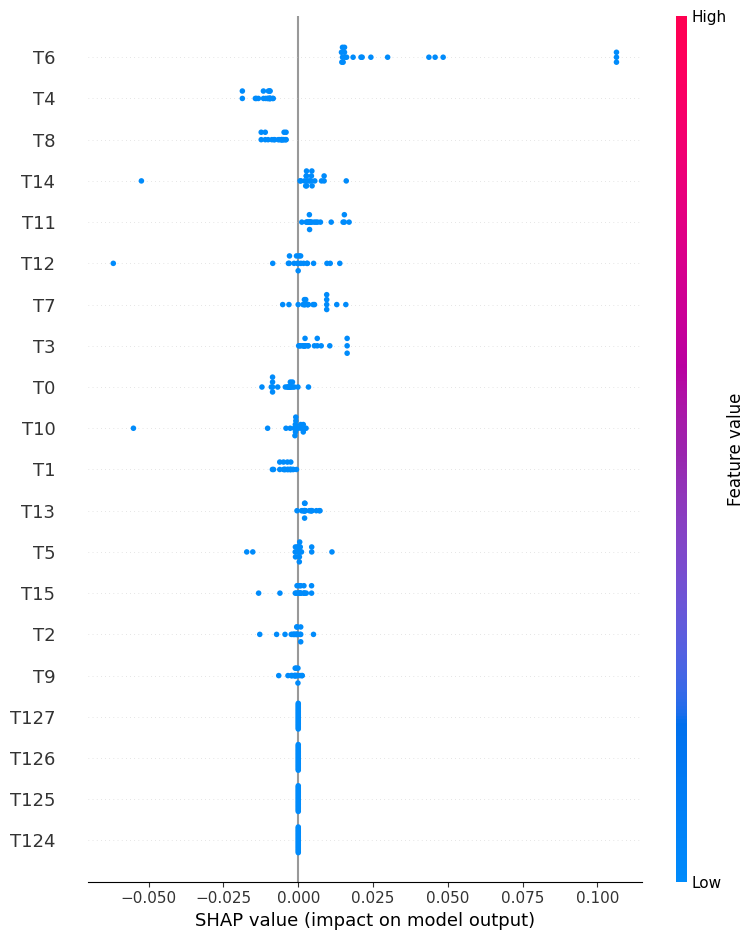

SHAP explanation completed on real test data.


In [ ]:
# ==============================
# SHAP Explanations for Trained LogBERT
# ==============================
import os, json, numpy as np, torch, shap
from tqdm import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# -----------------------------
# 0️⃣ Paths & device
# -----------------------------
MODEL_PATH = "/content/01_model_final1.pt"
TOKENIZER_PATH = "/content/tokenizer.json"
TEST_JSONL = "/content/test.json"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 1️⃣ Manual config
# -----------------------------
config = {
    "vocab_size": 18,
    "max_len": 128,
    "hidden": 32,
    "n_layers": 6,
    "attn_heads": 8,
    "dropout": 0.3,
    "batch_size": 16,
    "lr": 2e-05,
    "epochs": 6
}

max_len = config["max_len"]
vocab_size = config["vocab_size"]
hidden = config["hidden"]
n_layers = config["n_layers"]
attn_heads = config["attn_heads"]
dropout = config["dropout"]

# -----------------------------
# 2️⃣ Load tokenizer
# -----------------------------
with open(TOKENIZER_PATH, "r") as f:
    log2idx = json.load(f)
PAD_ID = log2idx.get("<PAD>", 0)
UNK_ID = log2idx.get("<UNK>", 1)
print(f"Tokenizer loaded, vocab size: {len(log2idx)}")

# -----------------------------
# 3️⃣ Load model
# -----------------------------
from bert_pytorch.model.bert import BERT
from bert_pytorch.model.log_model import BERTLog

bert_model = BERT(
    vocab_size=vocab_size,
    max_len=max_len,
    hidden=hidden,
    n_layers=n_layers,
    attn_heads=attn_heads,
    dropout=dropout,
    is_logkey=True,
    is_time=False
).to(device)

model = BERTLog(bert_model, vocab_size=vocab_size).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Model loaded.")

# -----------------------------
# 4️⃣ Prepare test sequences
# -----------------------------
test_samples_tokens = []
test_seqids = []

with open(TEST_JSONL, "r") as f:
    for line in f:
        item = json.loads(line)
        seq_tokens = item.get("mapped_sequence", None)
        if seq_tokens is None:
            seq_tokens = item.get("numeric_sequence", None)
        if isinstance(seq_tokens, list) and len(seq_tokens) > 0 and isinstance(seq_tokens[0], list):
            seq = seq_tokens[0]
        elif isinstance(seq_tokens, list):
            seq = seq_tokens
        else:
            seq = []
        test_samples_tokens.append(seq)
        test_seqids.append(item.get("sequence_id", None))

print(f"Loaded {len(test_samples_tokens)} test samples.")

# Tokenize sequences
def tokens_to_ids(seq, mapper=log2idx, unk_token="<UNK>"):
    unk_id = mapper.get(unk_token, 1)
    return [mapper.get(tok, unk_id) for tok in seq]

int_samples = [tokens_to_ids(seq) for seq in test_samples_tokens]

# Pad sequences
padded_samples = pad_sequences(int_samples, maxlen=max_len, padding="post", truncating="post", value=PAD_ID)
padded_samples = np.asarray(padded_samples, dtype=np.int32)
print("Padded shape:", padded_samples.shape)

# -----------------------------
# 5️⃣ SHAP wrapper for model
# -----------------------------
def model_numpy_wrapper(x_batch_np):
    model.eval()
    input_ids = torch.tensor(x_batch_np, dtype=torch.long, device=device)
    batch_size, seq_len = input_ids.shape
    time_info = torch.zeros(batch_size, seq_len, dtype=torch.float32, device=device)
    with torch.no_grad():
        outputs = model(input_ids, time_info)
        logits = outputs.get("logkey_output") if isinstance(outputs, dict) else outputs
        if logits.dim() == 3:
            # average token logits for SHAP
            mask = (input_ids != PAD_ID).unsqueeze(-1).float()
            masked_logits = logits * mask
            denom = mask.sum(dim=1).clamp(min=1.0)
            logits = masked_logits.sum(dim=1) / denom
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
    return probs

# -----------------------------
# 6️⃣ SHAP Explainer
# -----------------------------
masker = shap.maskers.Independent(data=np.zeros((1, max_len), dtype=np.int32), max_samples=20)
explainer = shap.Explainer(model_numpy_wrapper, masker=masker)

# -----------------------------
# 7️⃣ Explain real test samples
# -----------------------------
n_to_explain = min(20, padded_samples.shape[0])
x_test_subset = padded_samples[:n_to_explain]

all_shap_values = []
for i in tqdm(range(x_test_subset.shape[0]), desc="Explaining samples"):
    sample = x_test_subset[i:i+1]
    try:
        sv = explainer(sample, max_evals=50)
        all_shap_values.append(sv)
    except Exception as e:
        print(f"SHAP failed for sample {i} (seqid={test_seqids[i]}): {e}")

# Aggregate SHAP values
values_list = [sv.values for sv in all_shap_values]
shap_values_arr = np.concatenate(values_list, axis=0)
features_for_plot = x_test_subset[:shap_values_arr.shape[0]]
feature_names = [f"T{i}" for i in range(max_len)]

# -----------------------------
# 8️⃣ SHAP summary plot
# -----------------------------
if shap_values_arr.ndim == 3:
    probs_batch = model_numpy_wrapper(features_for_plot)
    pred_classes = np.argmax(probs_batch, axis=1)
    shap_for_plot = np.array([shap_values_arr[idx, :, pred_classes[idx]] for idx in range(shap_values_arr.shape[0])])
    shap.summary_plot(shap_for_plot, features=features_for_plot, feature_names=feature_names, show=True)
else:
    shap.summary_plot(shap_values_arr, features=features_for_plot, feature_names=feature_names, show=True)

print("SHAP explanation completed on real test data.")


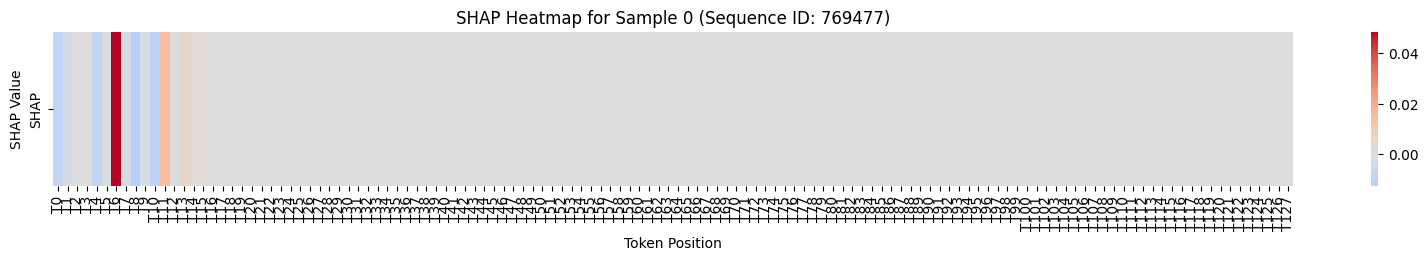

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1️⃣ Prepare SHAP values for heatmap
# -----------------------------
# For simplicity, let's use the first sample
sample_idx = 0
sample_seq = features_for_plot[sample_idx]

# If 3D (tokens x classes), pick predicted class
if shap_values_arr.ndim == 3:
    probs_batch = model_numpy_wrapper(sample_seq[np.newaxis, :])
    pred_class = np.argmax(probs_batch, axis=1)[0]
    shap_for_heatmap = shap_values_arr[sample_idx, :, pred_class]
else:
    shap_for_heatmap = shap_values_arr[sample_idx]

# -----------------------------
# 2️⃣ Token labels
# -----------------------------
token_labels = [f"T{i}" for i in range(len(sample_seq))]

# -----------------------------
# 3️⃣ Plot heatmap
# -----------------------------
plt.figure(figsize=(20, 2))
sns.heatmap([shap_for_heatmap], annot=False, cmap="coolwarm", center=0, xticklabels=token_labels, yticklabels=["SHAP"])
plt.title(f"SHAP Heatmap for Sample {sample_idx} (Sequence ID: {test_seqids[sample_idx]})")
plt.xlabel("Token Position")
plt.ylabel("SHAP Value")
plt.show()


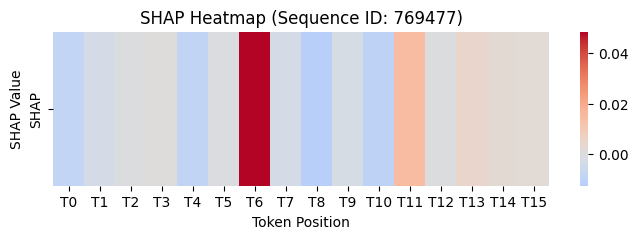

In [ ]:
# Mask only real tokens
mask_real = sample_seq != PAD_ID
shap_for_heatmap_real = shap_for_heatmap[mask_real]
token_labels_real = [f"T{i}" for i, m in enumerate(mask_real) if m]

plt.figure(figsize=(len(token_labels_real)/2, 2))
sns.heatmap([shap_for_heatmap_real], annot=False, cmap="coolwarm", center=0,
            xticklabels=token_labels_real, yticklabels=["SHAP"])
plt.title(f"SHAP Heatmap (Sequence ID: {test_seqids[sample_idx]})")
plt.xlabel("Token Position")
plt.ylabel("SHAP Value")
plt.show()


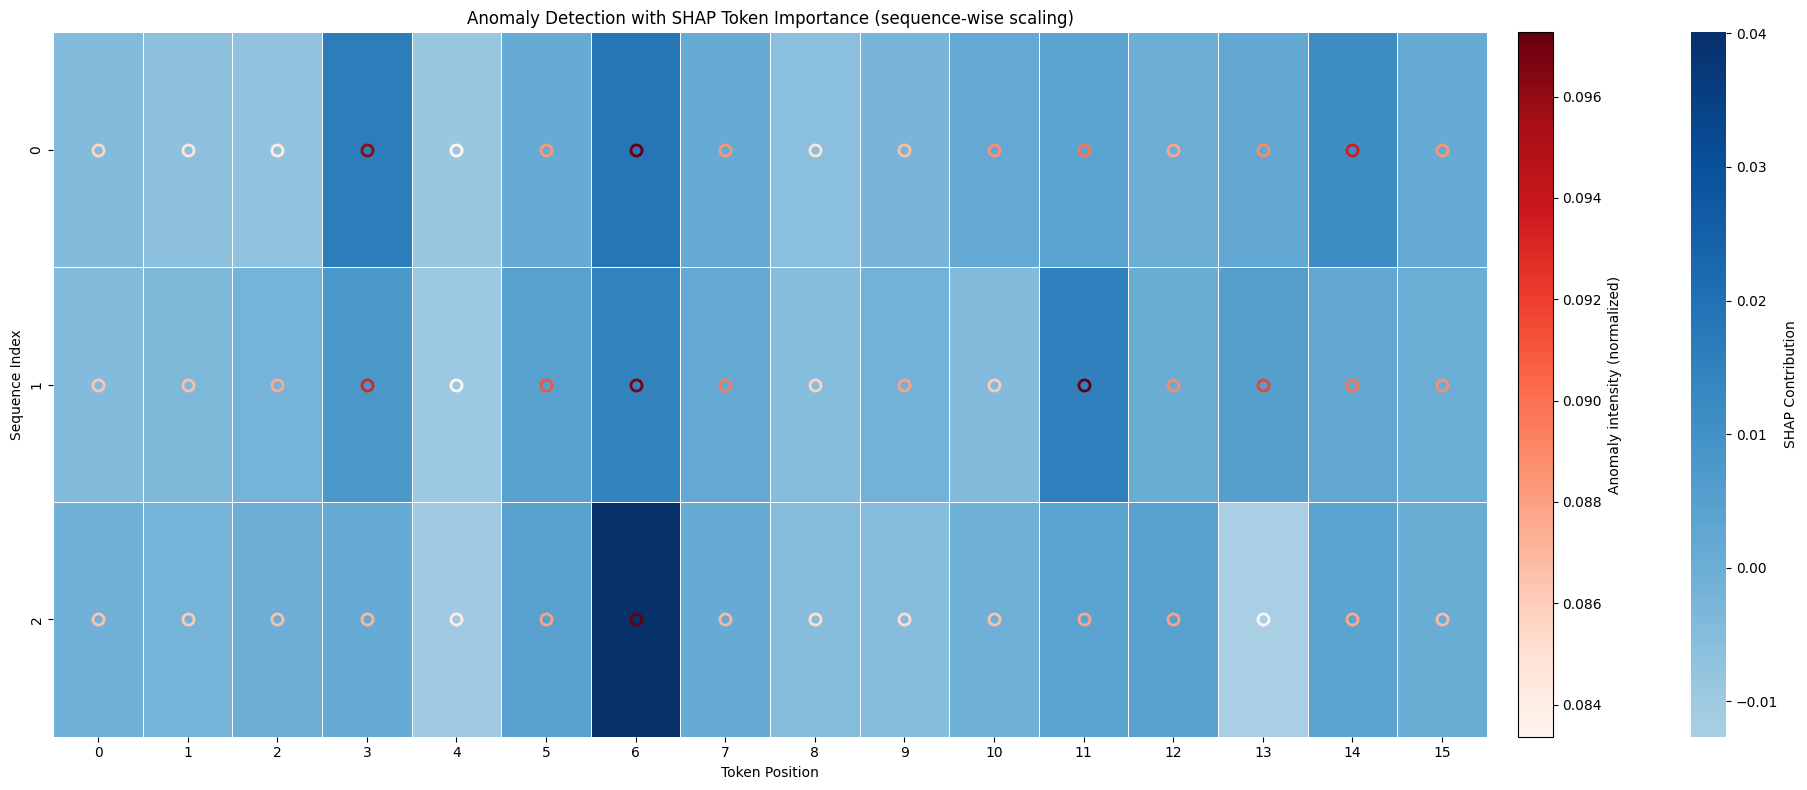

In [ ]:
# -----------------------------
# Normalize SHAP per sequence
# -----------------------------
norm_shap_seq = np.zeros_like(heatmap_matrix)
for i in range(num_sequences):
    seq_vals = heatmap_matrix[i]
    mask_real = seq_vals != 0
    if np.any(mask_real):
        real_vals = seq_vals[mask_real]
        norm_vals = (real_vals - real_vals.min()) / (real_vals.max() - real_vals.min() + 1e-8)
        norm_shap_seq[i, mask_real] = norm_vals

# -----------------------------
# Plot heatmap with sequence-wise normalized red circles
# -----------------------------
fig, ax0 = plt.subplots(figsize=(20, 8))
sns.heatmap(
    heatmap_matrix,
    cmap="Blues",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'SHAP Contribution'},
    ax=ax0
)

for i in range(num_sequences):
    for j in range(seq_len):
        if heatmap_matrix[i, j] != 0:
            ax0.plot(j + 0.5, i + 0.5, marker='o', markersize=8,
                     markerfacecolor='none',
                     markeredgecolor=cm.Reds(norm_shap_seq[i, j]),
                     markeredgewidth=2)

# Rightmost anomaly column
red_column = norm_scores[:, np.newaxis]
ax0.imshow(red_column, cmap='Reds', aspect='auto',
           extent=[seq_len, seq_len+1, 0, num_sequences])

ax0.set_xlabel("Token Position")
ax0.set_ylabel("Sequence Index")
ax0.set_title("Anomaly Detection with SHAP Token Importance (sequence-wise scaling)")

# Colorbar for anomaly intensity
sm = cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=anomaly_scores.min(), vmax=anomaly_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, fraction=0.05, pad=0.02)
cbar.set_label("Anomaly intensity (normalized)")

plt.tight_layout()
plt.show()


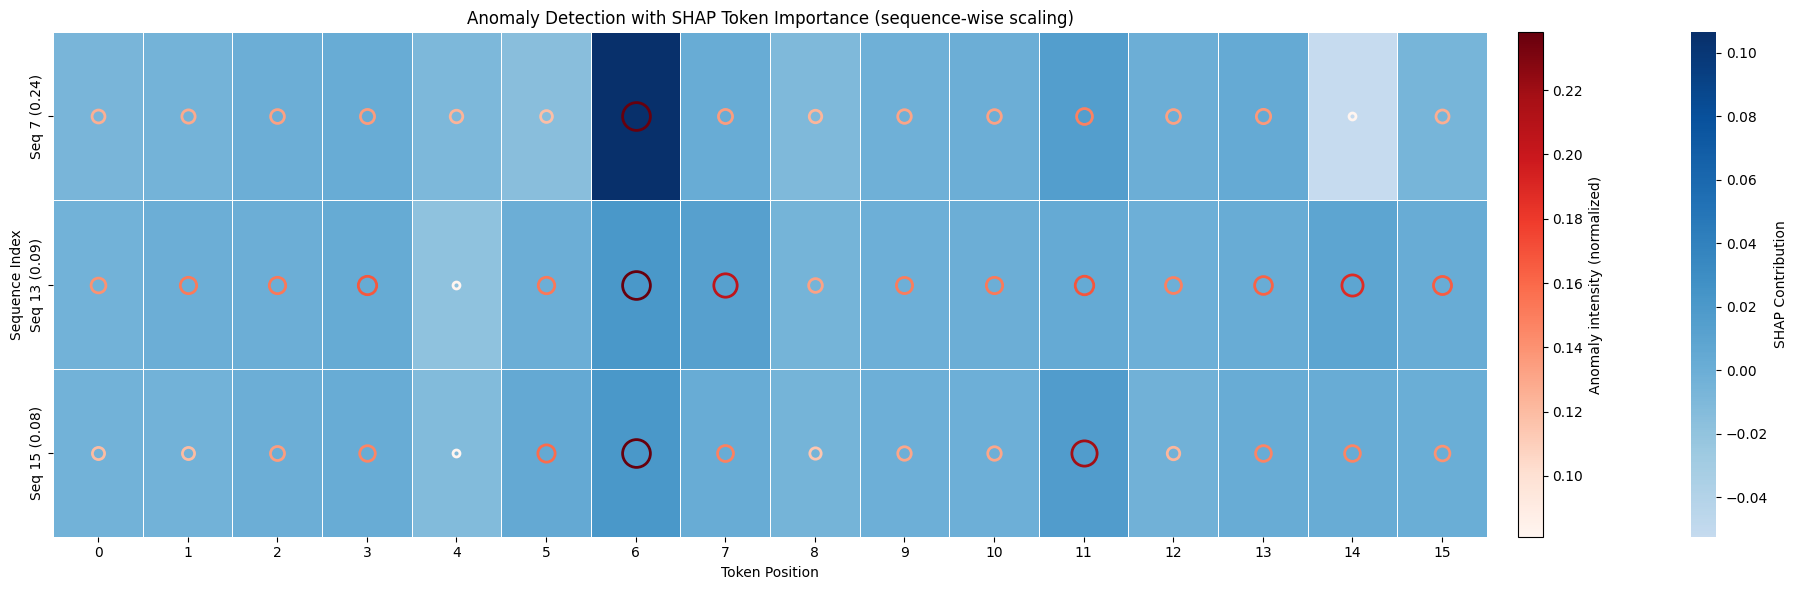

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import cm

# -----------------------------
# 0️⃣ Constants / Inputs
# -----------------------------
selected_indices = [7, 13, 15]  # sequences to plot
PAD_ID = 0                      # padding ID
num_sequences = len(selected_indices)

# -----------------------------
# 1️⃣ Build heatmap_matrix for selected sequences
# -----------------------------
heatmap_matrix = []

for idx in selected_indices:
    seq_ids = features_for_plot[idx]  # token IDs for this sequence
    mask_real = seq_ids != PAD_ID

    # Handle SHAP shape
    if shap_values_arr.ndim == 3:
        probs = model_numpy_wrapper(seq_ids[np.newaxis, :])
        pred_class = np.argmax(probs, axis=1)[0]
        shap_vals = shap_values_arr[idx, :, pred_class]
    else:
        shap_vals = shap_values_arr[idx]

    heatmap_matrix.append(shap_vals[mask_real])

# Pad sequences to the same length
max_len_seq = max(len(seq) for seq in heatmap_matrix)
heatmap_matrix_padded = np.array([np.pad(seq, (0, max_len_seq - len(seq)), 'constant')
                                  for seq in heatmap_matrix])
heatmap_matrix = heatmap_matrix_padded
num_sequences, seq_len = heatmap_matrix.shape

# -----------------------------
# 2️⃣ Normalize SHAP per sequence (for circle size/intensity)
# -----------------------------
norm_shap_seq = np.zeros_like(heatmap_matrix)
for i in range(num_sequences):
    seq_vals = heatmap_matrix[i]
    mask_real = seq_vals != 0
    if np.any(mask_real):
        real_vals = seq_vals[mask_real]
        norm_vals = (real_vals - real_vals.min()) / (real_vals.max() - real_vals.min() + 1e-8)
        norm_shap_seq[i, mask_real] = norm_vals

# -----------------------------
# 3️⃣ Compute anomaly scores per sequence
# -----------------------------
abs_shap = np.abs(heatmap_matrix)
anomaly_scores = np.sum(abs_shap, axis=1)
norm_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min() + 1e-8)

# -----------------------------
# 4️⃣ Plot heatmap
# -----------------------------
fig, ax0 = plt.subplots(figsize=(20, 6))
sns.heatmap(
    heatmap_matrix,
    cmap="Blues",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'SHAP Contribution'},
    ax=ax0
)

# -----------------------------
# 5️⃣ Red circles with size proportional to SHAP magnitude
# -----------------------------
min_marker, max_marker = 5, 20
for i in range(num_sequences):
    for j in range(seq_len):
        if heatmap_matrix[i, j] != 0:
            color_intensity = norm_shap_seq[i, j]
            size = min_marker + color_intensity * (max_marker - min_marker)
            ax0.plot(j + 0.5, i + 0.5, marker='o', markersize=size,
                     markerfacecolor='none',
                     markeredgecolor=cm.Reds(color_intensity),
                     markeredgewidth=2)

# -----------------------------
# 6️⃣ Rightmost anomaly column
# -----------------------------
red_column = norm_scores[:, np.newaxis]
ax0.imshow(red_column, cmap='Reds', aspect='auto',
           extent=[seq_len, seq_len+1, 0, num_sequences])

# -----------------------------
# 7️⃣ Y-axis labels with anomaly scores
# -----------------------------
seq_labels = [f"Seq {idx} ({anomaly_scores[i]:.2f})" for i, idx in enumerate(selected_indices)]
ax0.set_yticks(np.arange(num_sequences) + 0.5)
ax0.set_yticklabels(seq_labels, fontsize=10)

ax0.set_xlabel("Token Position")
ax0.set_ylabel("Sequence Index")
ax0.set_title("Anomaly Detection with SHAP Token Importance (sequence-wise scaling)")

# -----------------------------
# 8️⃣ Colorbar for anomaly intensity
# -----------------------------
sm = cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=anomaly_scores.min(), vmax=anomaly_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, fraction=0.05, pad=0.02)
cbar.set_label("Anomaly intensity (normalized)")

plt.tight_layout()
plt.show()


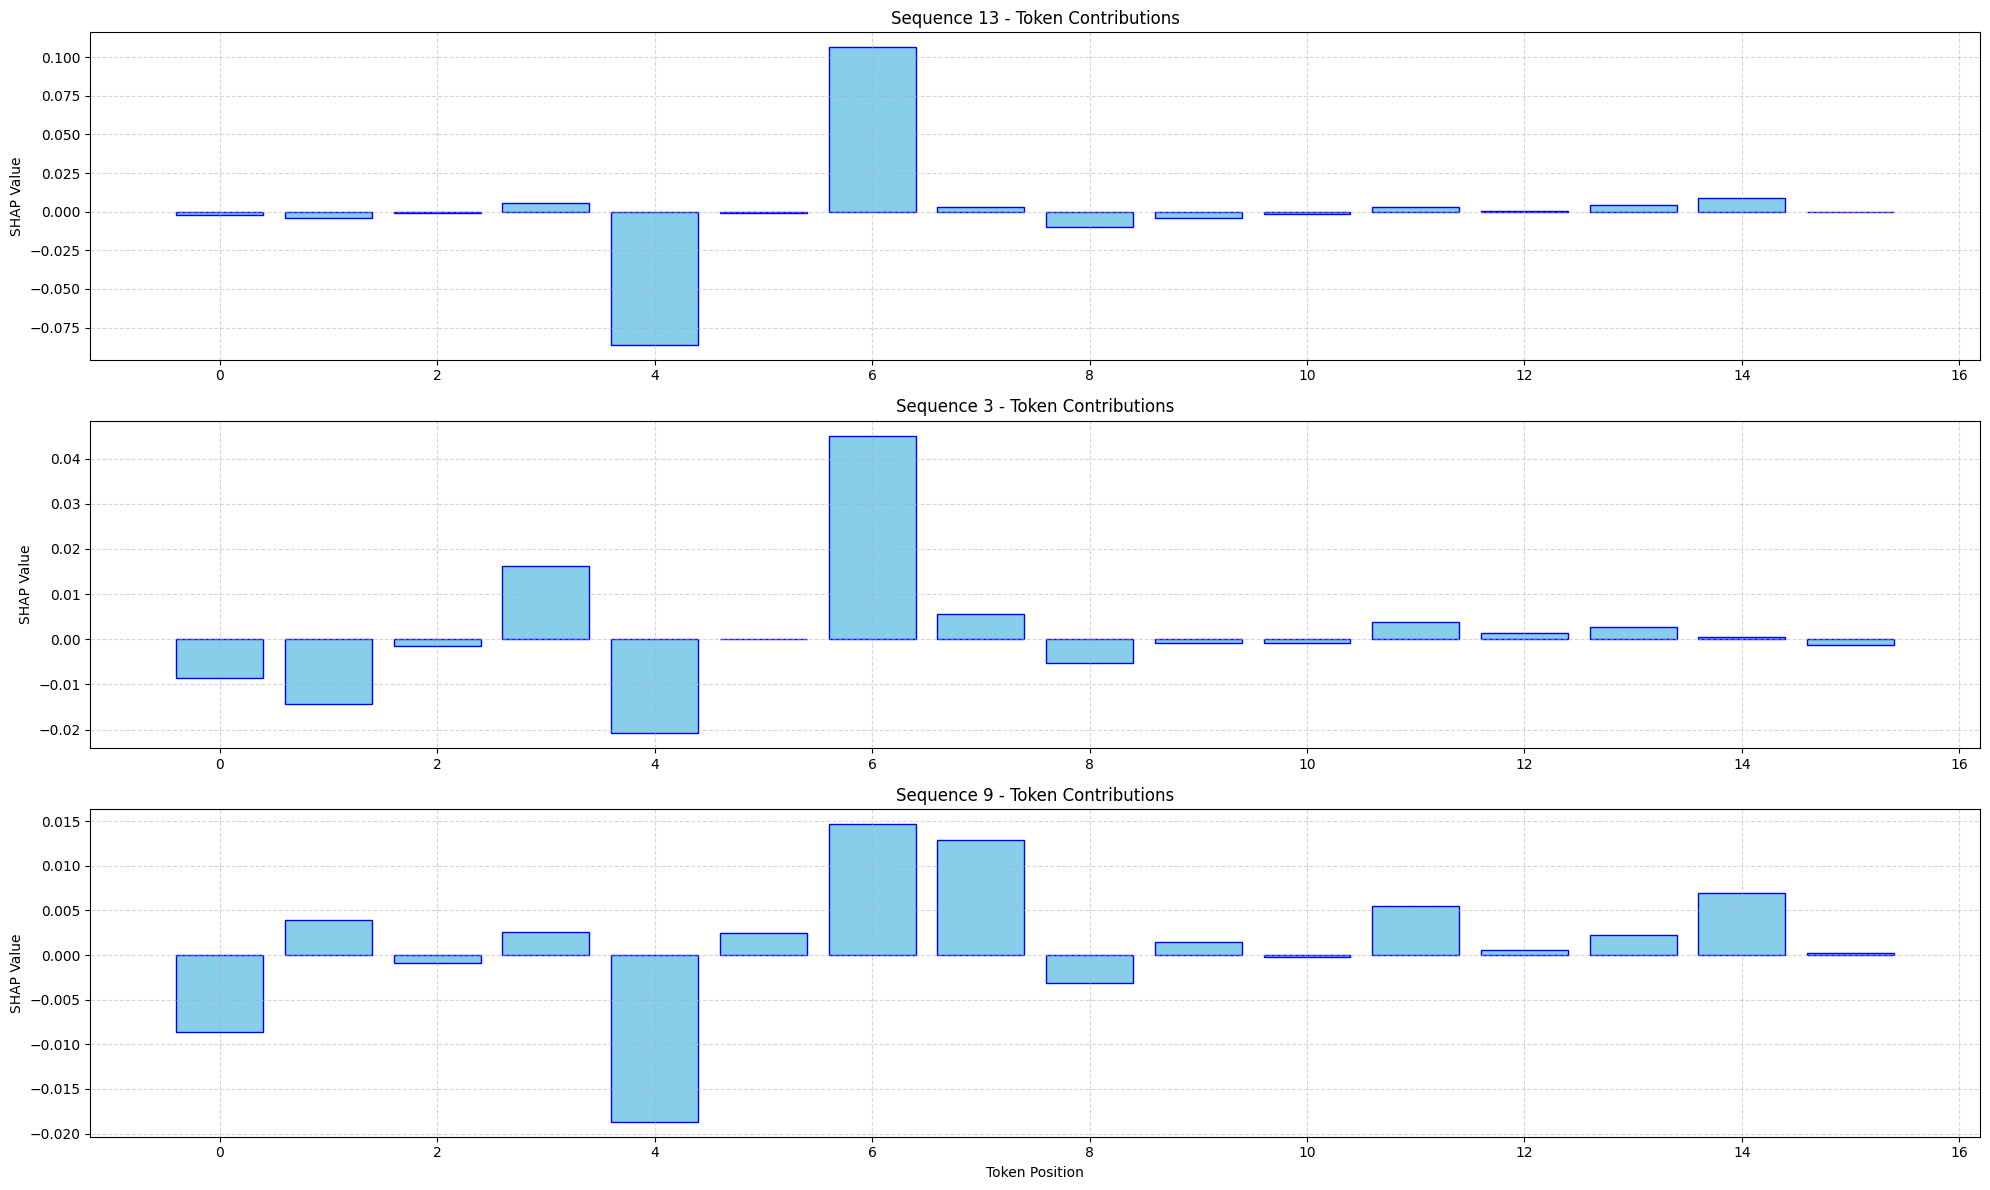

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# Selected sequences
# -----------------------------
selected_indices = [13, 3, 9]
num_sequences = len(selected_indices)

# -----------------------------
# Prepare SHAP values per sequence
# -----------------------------
shap_sequences = []
token_labels_sequences = []

for idx in selected_indices:
    seq_ids = features_for_plot[idx]
    mask_real = seq_ids != PAD_ID

    if shap_values_arr.ndim == 3:
        probs = model_numpy_wrapper(seq_ids[np.newaxis, :])
        pred_class = np.argmax(probs, axis=1)[0]
        shap_vals = shap_values_arr[idx, :, pred_class]
    else:
        shap_vals = shap_values_arr[idx]

    shap_sequences.append(shap_vals[mask_real])
    token_labels_sequences.append(seq_ids[mask_real])  # you can map to strings if available

# -----------------------------
# Plot SHAP values per sequence as bar/line
# -----------------------------
fig, axs = plt.subplots(num_sequences, 1, figsize=(20, 4*num_sequences), sharex=False)

for i in range(num_sequences):
    x = np.arange(len(shap_sequences[i]))
    y = shap_sequences[i]

    axs[i].bar(x, y, color='skyblue', edgecolor='blue')
    axs[i].set_ylabel("SHAP Value")
    axs[i].set_title(f"Sequence {selected_indices[i]} - Token Contributions")
    axs[i].grid(True, linestyle='--', alpha=0.5)

    # Optionally, display token labels on x-axis if available
    # axs[i].set_xticks(x)
    # axs[i].set_xticklabels(token_labels_sequences[i], rotation=90, fontsize=8)

axs[-1].set_xlabel("Token Position")
plt.tight_layout()
plt.show()


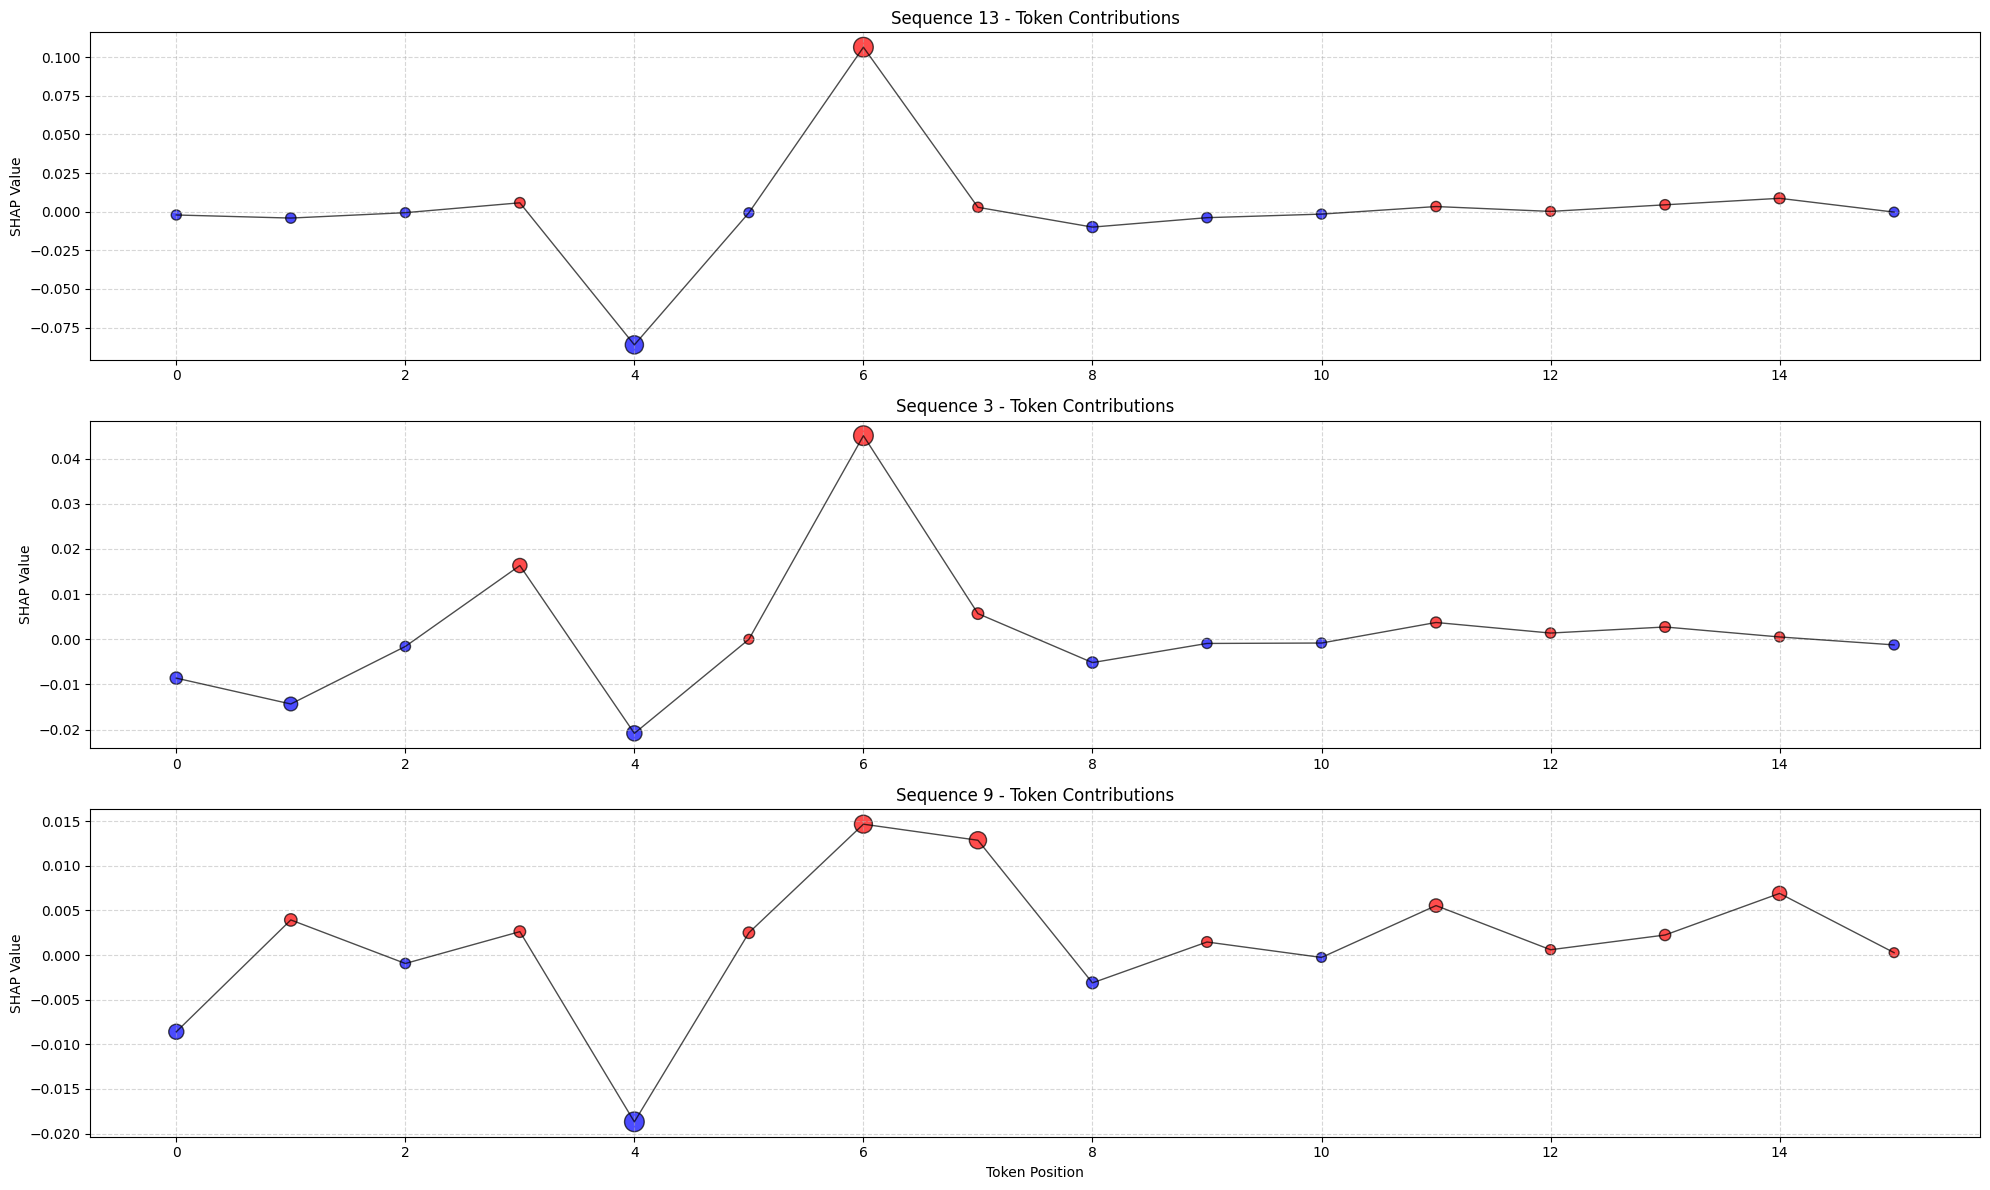

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# -----------------------------
# Selected sequences
# -----------------------------
selected_indices = [13, 3, 9]
num_sequences = len(selected_indices)

shap_sequences = []
token_labels_sequences = []

for idx in selected_indices:
    seq_ids = features_for_plot[idx]
    mask_real = seq_ids != PAD_ID

    # Extract SHAP values for predicted class
    if shap_values_arr.ndim == 3:
        probs = model_numpy_wrapper(seq_ids[np.newaxis, :])
        pred_class = np.argmax(probs, axis=1)[0]
        shap_vals = shap_values_arr[idx, :, pred_class]
    else:
        shap_vals = shap_values_arr[idx]

    shap_sequences.append(shap_vals[mask_real])
    token_labels_sequences.append(seq_ids[mask_real])  # or map to strings if available

# -----------------------------
# Plot line + circle for each sequence
# -----------------------------
fig, axs = plt.subplots(num_sequences, 1, figsize=(20, 4*num_sequences), sharex=False)

for i in range(num_sequences):
    x = np.arange(len(shap_sequences[i]))
    y = shap_sequences[i]

    # Normalize magnitude for circle size
    norm_mag = (np.abs(y) - np.min(np.abs(y))) / (np.max(np.abs(y)) - np.min(np.abs(y)) + 1e-8)
    sizes = 50 + norm_mag * 150  # min 50, max 200

    # Circle colors: red for positive, blue for negative
    colors = ['red' if val > 0 else 'blue' for val in y]

    # Plot line
    axs[i].plot(x, y, color='black', linestyle='-', linewidth=1, alpha=0.7)

    # Plot circles
    axs[i].scatter(x, y, s=sizes, c=colors, alpha=0.7, edgecolors='k')

    axs[i].set_ylabel("SHAP Value")
    axs[i].set_title(f"Sequence {selected_indices[i]} - Token Contributions")
    axs[i].grid(True, linestyle='--', alpha=0.5)

    # Optional: add token strings on x-axis
    # axs[i].set_xticks(x)
    # axs[i].set_xticklabels(token_labels_sequences[i], rotation=90, fontsize=8)

axs[-1].set_xlabel("Token Position")
plt.tight_layout()
plt.show()
